In [1]:
from torch.utils import data as data
import pandas as pd
from torchvision.transforms.functional import normalize
from tqdm import tqdm
import os
from basicsr.data.data_util import (paired_paths_from_folder,
                                    paired_paths_from_lmdb,
                                    paired_paths_from_meta_info_file)
from basicsr.data.transforms import augment, paired_random_crop
from basicsr.utils import FileClient, imfrombytes, img2tensor, padding
from torch.utils.data.dataloader import default_collate
import h5py
# local modules
from basicsr.data.h5_augment import *
import cv2
import matplotlib.pyplot as plt
import numpy as np

def transform_voxel(voxel, transpose_to_CHW=False, norm_voxel = True):
    """
    Augment voxel and turn into tensor
    @param voxel Input voxel
    @param seed  Seed for random number generation
    @returns Augmented voxel
    """

    if transpose_to_CHW:
        voxel = torch.from_numpy(voxel.transpose(2, 0, 1)).float()# H,W,C -> C,H,W

    else:
        if norm_voxel:
            voxel = torch.from_numpy(voxel).float() / abs(max(voxel.min(), voxel.max(), key=abs))  # -1 ~ 1
        else:
            voxel = torch.from_numpy(voxel).float()

    # if self.vox_transform:
    #     random.seed(seed)
    #     voxel = self.vox_transform(voxel)
    return voxel

/opt/conda/envs/deblur/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FFT Loss

In [2]:
import torch
from torch import nn as nn
from torch.nn import functional as F
import numpy as np

from basicsr.models.losses.loss_util import weighted_loss

_reduction_modes = ['none', 'mean', 'sum']


@weighted_loss
def l1_loss(pred, target):
    return F.l1_loss(pred, target, reduction='none')

class FFTLoss(nn.Module):
    """L1 loss in frequency domain using log1p of FFT magnitude.

    Args:
        loss_weight (float): Loss weight for FFT loss. Default: 1.0.
        reduction (str): Specifies the reduction to apply to the output.
            Supported choices are 'none' | 'mean' | 'sum'. Default: 'mean'.
    """
    def __init__(self, loss_weight=1.0, reduction='mean'):
        super(FFTLoss, self).__init__()
        if reduction not in ['none', 'mean', 'sum']:
            raise ValueError(f'Unsupported reduction mode: {reduction}. '
                             f'Supported ones are: {["none", "mean", "sum"]}')
        self.loss_weight = loss_weight
        self.reduction = reduction

    def forward(self, pred, target, weight=None, **kwargs):
        """
        Args:
            pred (Tensor): of shape (..., C, H, W). Predicted tensor.
            target (Tensor): of shape (..., C, H, W). Ground truth tensor.
            weight (Tensor, optional): of shape (..., C, H, W). Element-wise weights. Default: None.
        Returns:
            L1 loss between the log1p(FFT magnitude) of pred and target.
        """
        # 1) FFT 변환
        pred_fft = torch.fft.fft2(pred, dim=(-2, -1))
        target_fft = torch.fft.fft2(target, dim=(-2, -1))
        
        # 2) Magnitude 계산
        pred_mag = torch.abs(pred_fft)
        target_mag = torch.abs(target_fft)

        # 3) log1p로 동적 범위 압축
        #    log1p(x) = log(1 + x)
        pred_log = torch.log1p(pred_mag)
        target_log = torch.log1p(target_mag)

        # 4) L1 Loss 계산
        loss = l1_loss(pred_log, target_log, reduction=self.reduction)
        return self.loss_weight * loss

# FFT 시각화

/workspace/data/GOPRO/train/GOPR0380_11_00.h5


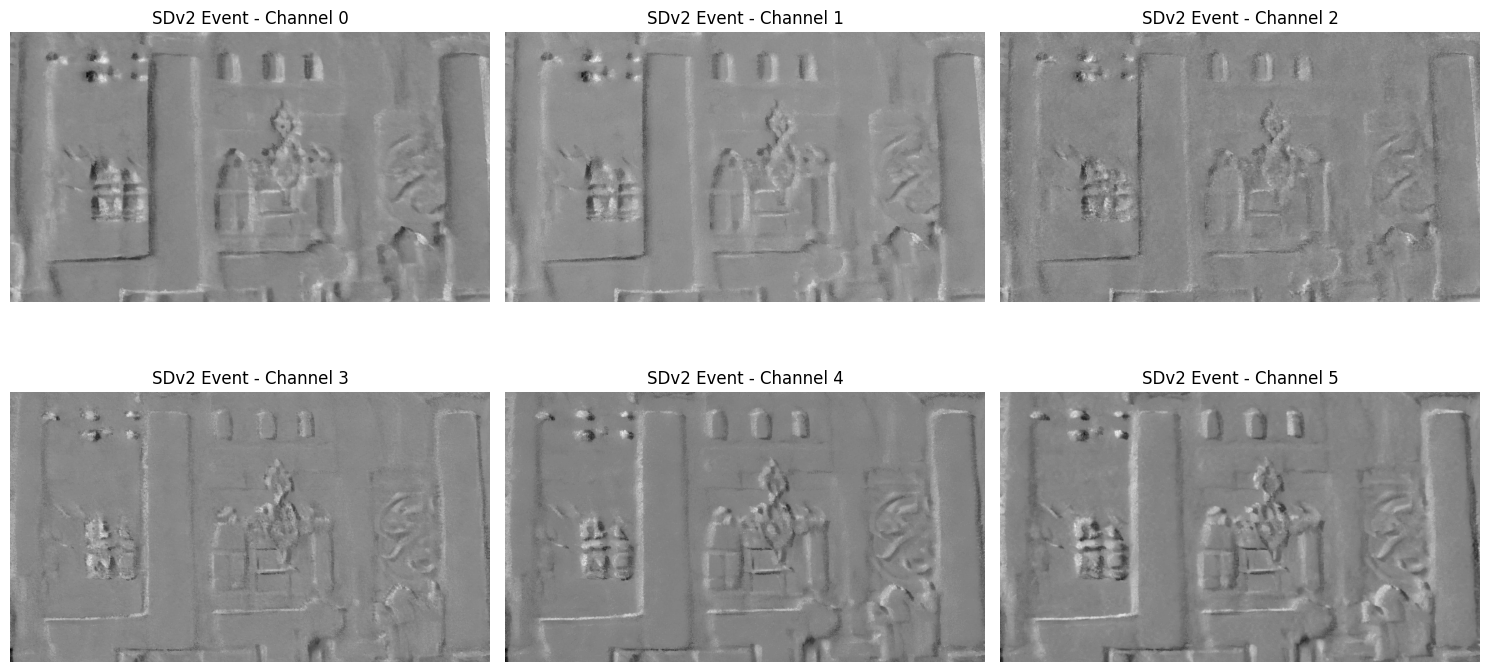

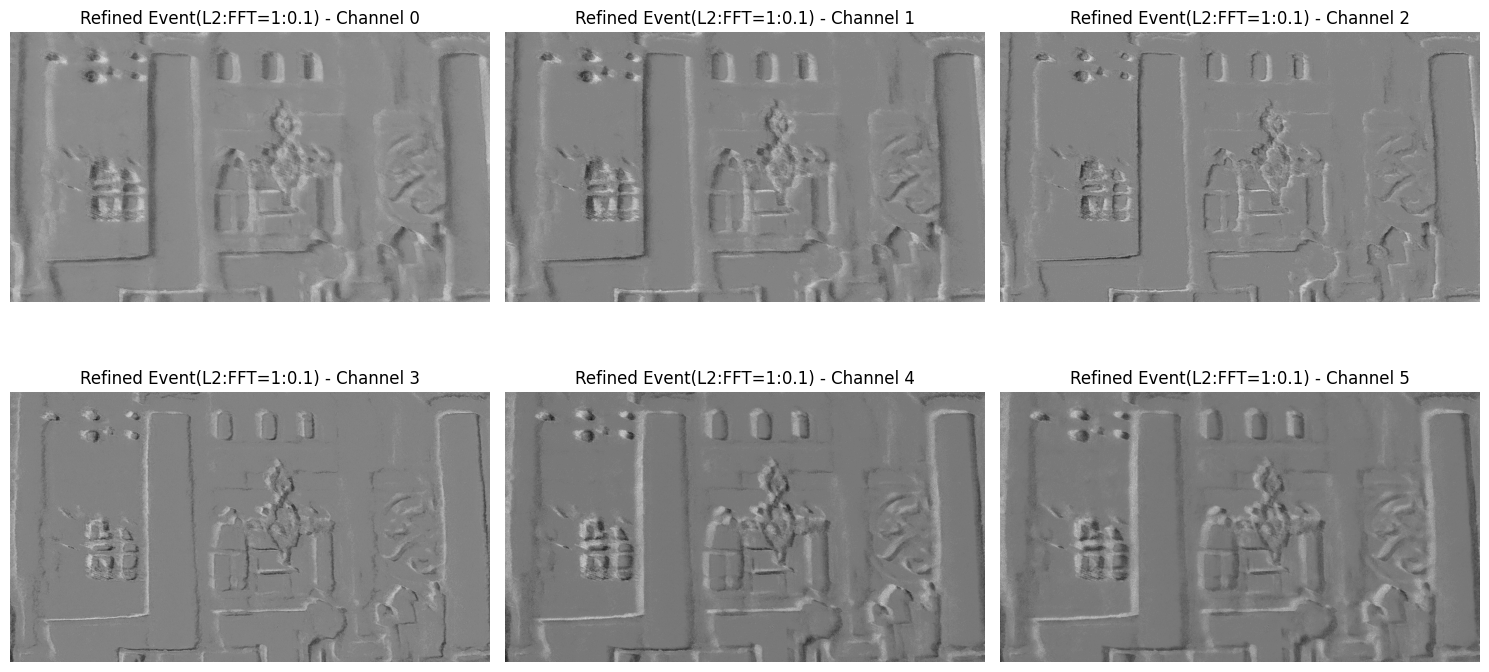

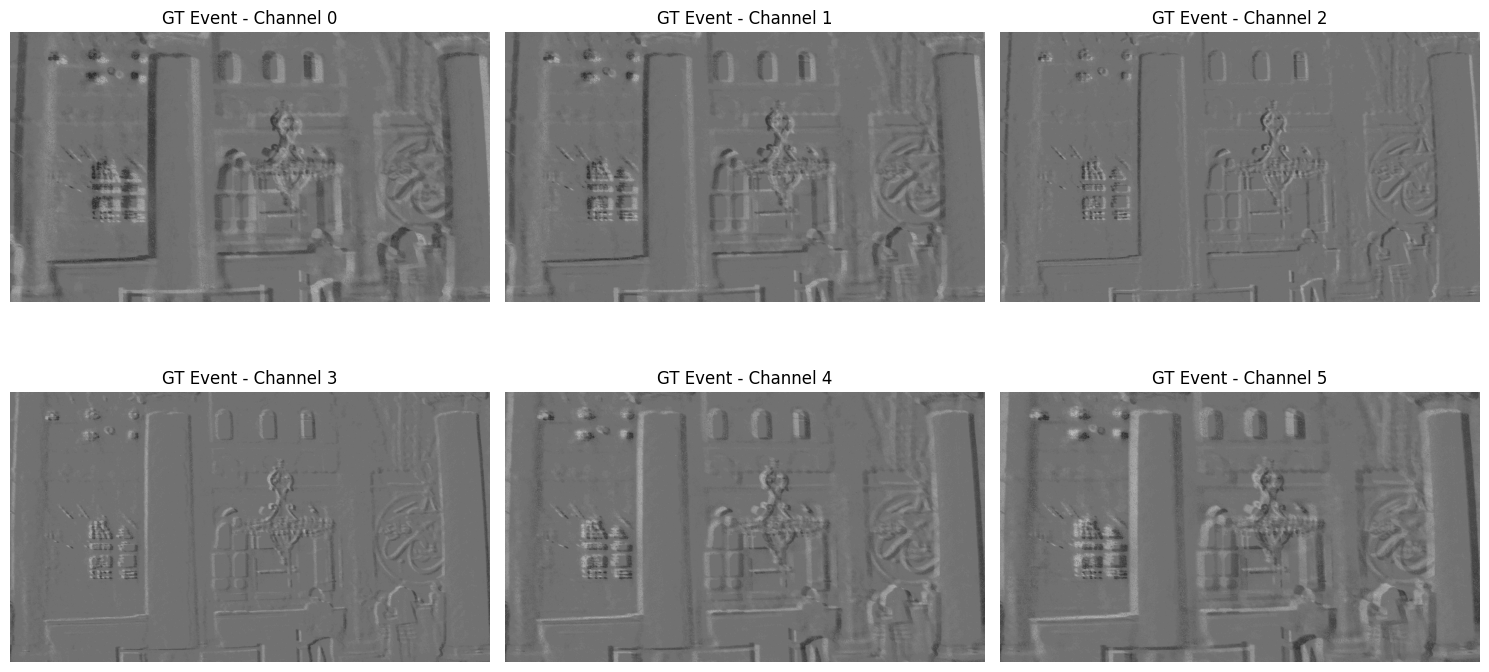

tensor(1.5344)
tensor(1.4170)
tensor(1.2798)
tensor(1.2523)
tensor(1.4065)
tensor(1.5483)


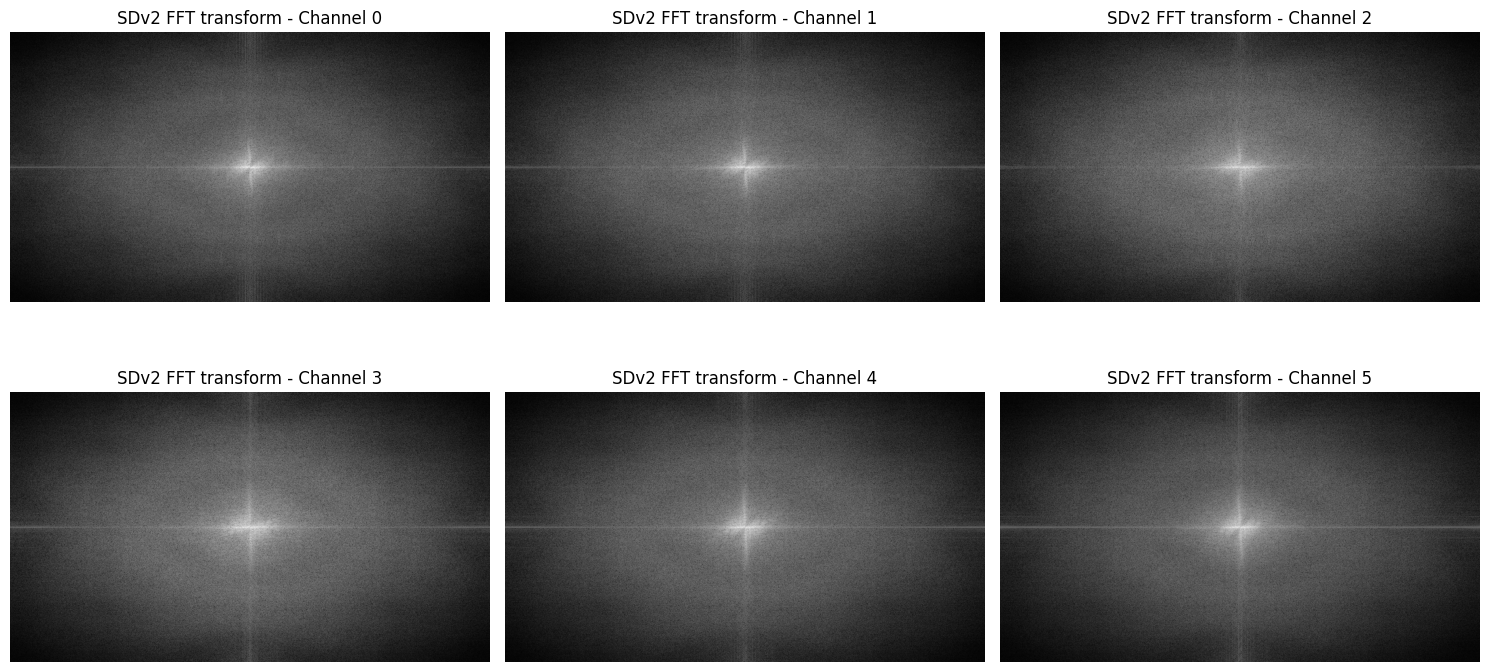

tensor(0.6646)
tensor(0.6599)
tensor(0.6526)
tensor(0.6514)
tensor(0.6587)
tensor(0.6642)


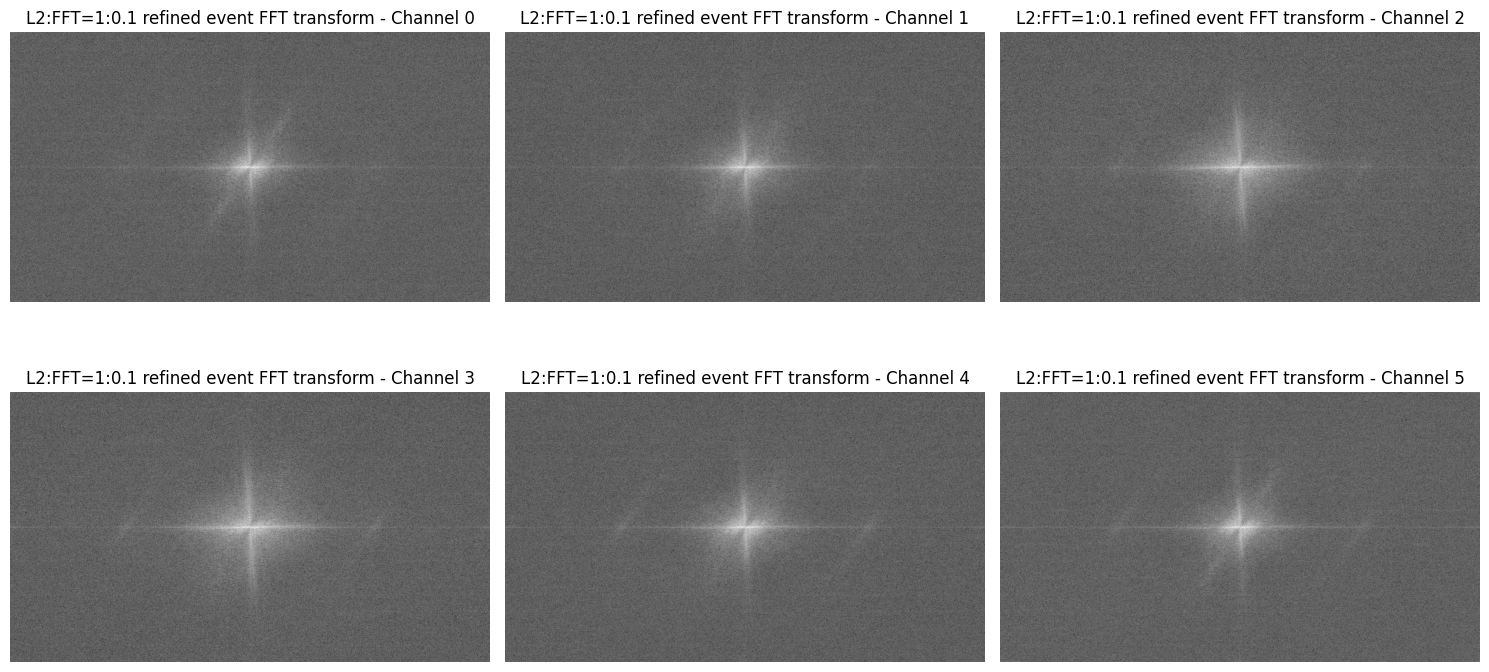

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


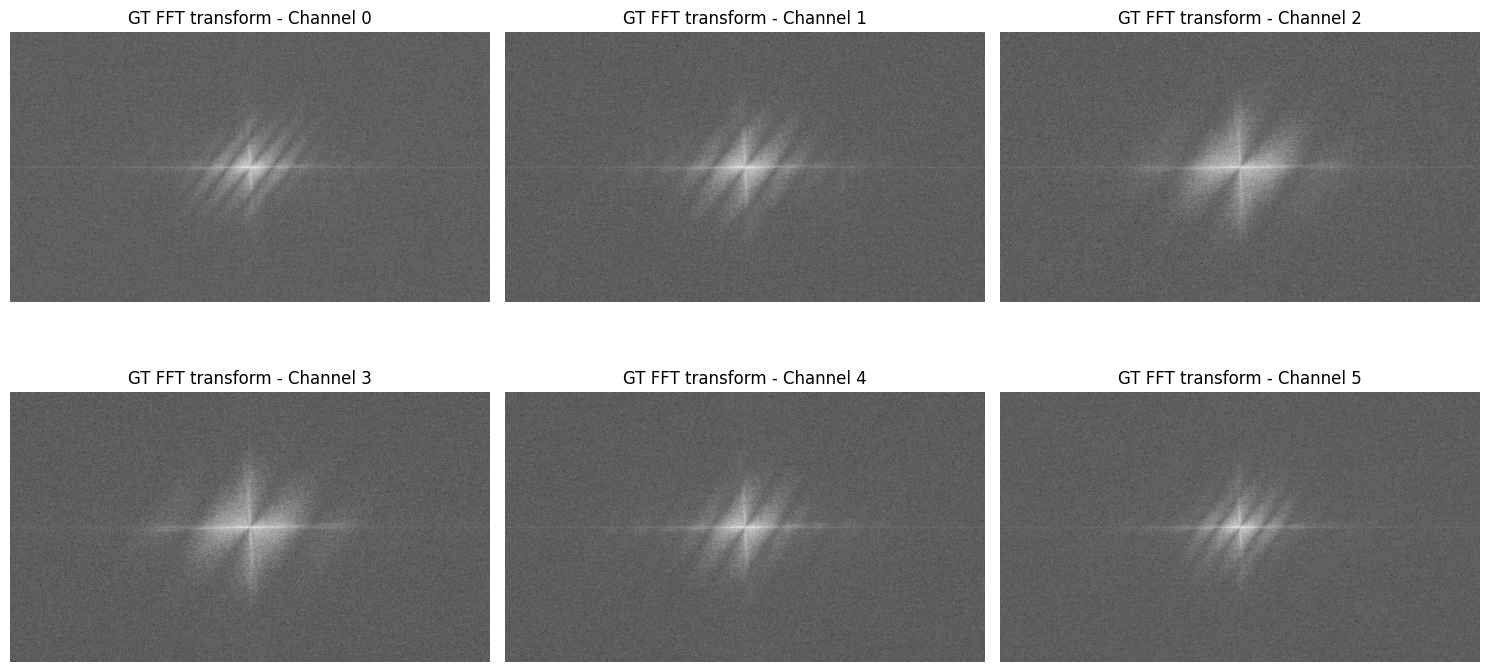

In [32]:
data_path = '/workspace/data/GOPRO/train/'
h5_folder = os.listdir(data_path)
h5_folder.sort()
datasets = []

idx = '000000000'
for h5 in h5_folder[8:]:
    imgs_path = os.path.join(data_path,h5)
    h5_file = h5py.File(imgs_path,'r')
    print(imgs_path)

    h5_file
    break

event =h5_file['gen_event'][f'image{idx}'][:]
blur_img = h5_file['images'][f'image{idx}'][:]
blur_img = blur_img.transpose(1,2,0)
# sharp_img = h5_file['sharp_images'][f'image{idx}'][:]
voxel = h5_file['voxels'][f'voxel{idx}'][:]
refine_event = h5_file['gen_event_fft'][f'image{idx}'][:]
refine_event = refine_event.transpose(1,2,0)

n_event = np.array(event)
voxel = np.array(voxel)
voxel = np.array(transform_voxel(voxel))
scene = h5[:-3]

cri_fft = FFTLoss()


# n_event = n_event[:,:256,:256]
# voxel = voxel[:,:256,:256]
# refine_event = refine_event[:,:256,:256]


event_data_list = [
    (n_event, 'SDv2 Event'),
    (refine_event, 'Refined Event(L2:FFT=1:0.1)'),
    (voxel, 'GT Event'),

    (n_event, 'SDv2 FFT transform'),
    (refine_event, 'L2:FFT=1:0.1 refined event FFT transform'),
    (voxel, 'GT FFT transform'),
]

# 각 이벤트 데이터에 대해 2행 3열 subplot에 6개 채널 시각화
for event_data, title in event_data_list:
    # 새로운 figure 생성 (크기는 필요에 따라 조정)
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    axs = axs.ravel()  # 2차원 배열을 1차원으로 평탄화하여 편하게 접근

    # 각 채널 순회 (총 6채널)
    for ch in range(6):
        # 채널 데이터 추출
        channel_data = event_data[ch]

        out_channel_data = event_data[ch]
        gt_channel_data = voxel[ch]

        if 'transform' in title:
            # FFT 적용: 데이터를 tensor로 변환 후 2D FFT, fftshift, magnitude, log scale 적용
            t_data = torch.tensor(channel_data, dtype=torch.float32)
            t_fft = torch.fft.fft2(t_data)
            t_fft = torch.fft.fftshift(t_fft)
            mag = torch.abs(t_fft)
            # log1p를 사용하여 log(1+mag) 계산 (값의 dynamic range 감소)
            channel_data = torch.log1p(mag).numpy()

            fft_loss = cri_fft(torch.tensor(out_channel_data),torch.tensor(gt_channel_data))
            print(fft_loss)
        else:
            # [-1,1] 범위 데이터를 [0,1] 범위로 단순 스케일링
            channel_data = (channel_data + 1) / 2

        # subplot에 채널 이미지 표시
        axs[ch].imshow(channel_data, cmap='gray')
        axs[ch].set_title(f"{title} - Channel {ch}")
        axs[ch].axis('off')

    plt.tight_layout()
    plt.show()


Channel correlation matrix:
[[ 1.          0.72168894  0.55765371 -0.00659643  0.06815893  0.12225999]
 [ 0.72168894  1.          0.81135751 -0.01459441 -0.00305871  0.02612467]
 [ 0.55765371  0.81135751  1.         -0.00339076 -0.04120991 -0.01471584]
 [-0.00659643 -0.01459441 -0.00339076  1.          0.77685876  0.62487125]
 [ 0.06815893 -0.00305871 -0.04120991  0.77685876  1.          0.91077055]
 [ 0.12225999  0.02612467 -0.01471584  0.62487125  0.91077055  1.        ]]


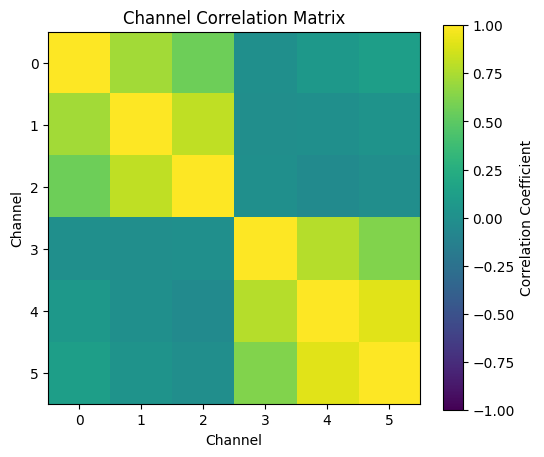

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def compute_channel_correlations(event):
    """
    주어진 이벤트 데이터에서 각 채널 간의 피어슨 상관계수를 계산합니다.
    
    Args:
        event (numpy.ndarray): shape = (6, H, W)
    
    Returns:
        corr_matrix (numpy.ndarray): 6x6 상관관계 행렬
    """
    channels = event.shape[0]
    # 각 채널을 1차원으로 평탄화하여 배열로 만듦 (shape: (6, N))
    flattened_channels = np.array([event[ch].flatten() for ch in range(channels)])
    
    # np.corrcoef는 각 행 간의 피어슨 상관계수를 계산합니다.
    corr_matrix = np.corrcoef(flattened_channels)
    return corr_matrix

# 예시: refine_event 데이터가 (6, H, W) 형태라고 가정
# refine_event = ... (이미 numpy 배열로 되어 있음)
corr_matrix = compute_channel_correlations(refine_event)
print("Channel correlation matrix:")
print(corr_matrix)

# 상관관계 행렬 시각화
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.title("Channel Correlation Matrix")
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.xticks(np.arange(6))
plt.yticks(np.arange(6))
plt.show()


Channel correlation matrix:
[[ 1.          0.83530855  0.58083227  0.03205559  0.08216998  0.11706276]
 [ 0.83530855  1.          0.72595517 -0.00427284  0.04364795  0.08272619]
 [ 0.58083227  0.72595517  1.         -0.03575734 -0.00226085  0.03455509]
 [ 0.03205559 -0.00427284 -0.03575734  1.          0.73979757  0.58917267]
 [ 0.08216998  0.04364795 -0.00226085  0.73979757  1.          0.84291631]
 [ 0.11706276  0.08272619  0.03455509  0.58917267  0.84291631  1.        ]]


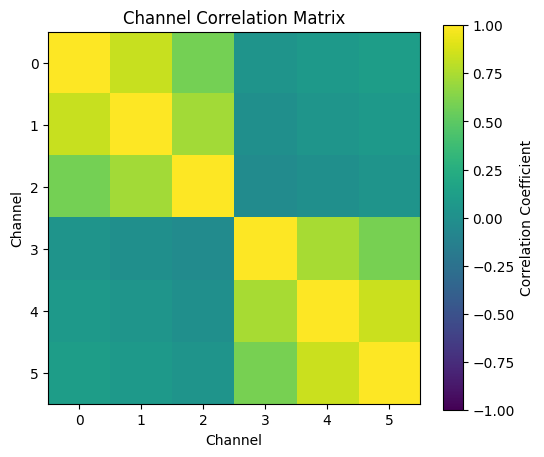

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def compute_channel_correlations(event):
    """
    주어진 이벤트 데이터에서 각 채널 간의 피어슨 상관계수를 계산합니다.
    
    Args:
        event (numpy.ndarray): shape = (6, H, W)
    
    Returns:
        corr_matrix (numpy.ndarray): 6x6 상관관계 행렬
    """
    channels = event.shape[0]
    # 각 채널을 1차원으로 평탄화하여 배열로 만듦 (shape: (6, N))
    flattened_channels = np.array([event[ch].flatten() for ch in range(channels)])
    
    # np.corrcoef는 각 행 간의 피어슨 상관계수를 계산합니다.
    corr_matrix = np.corrcoef(flattened_channels)
    return corr_matrix

# 예시: refine_event 데이터가 (6, H, W) 형태라고 가정
# refine_event = ... (이미 numpy 배열로 되어 있음)
corr_matrix = compute_channel_correlations(voxel)
print("Channel correlation matrix:")
print(corr_matrix)

# 상관관계 행렬 시각화
plt.figure(figsize=(6, 5))
plt.imshow(corr_matrix, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.title("Channel Correlation Matrix")
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.xticks(np.arange(6))
plt.yticks(np.arange(6))
plt.show()
